imports

In [ ]:
import random
from datetime import datetime,timedelta
import csv
from faker import Faker
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

## Goal: generate a list of task with the people on it and the deadline of each task

### First let's just try to determine the duration of a task

As no dataset lets generate our own one

In [ ]:
#task : desc,type,deadline,technologies,team,duration(the output that we try to guess)
#start: date of the task creation
#type : "bug", "feature", "refactor", "test", "documentation"
#technologies : "python", "java", "c++", "c#", "web", "sql", "nosql"
#team : number of people in the team
#priority : 0,1,2(0 :"low", 1:"medium", 2:"high")
#duration : in days
#deadline : a date in the future
#desc : a string

#generate a random but credible dataset of task

def generate_dataset(sample):
    
    fake = Faker()
    tasks = []
    desc_df = pd.read_csv("data/IT_tasks_list_with_logic.csv")

    for i in range(sample):
        min_duration = 1
        task = {}
        #select a random sample of the dataset
        random_sample = desc_df.sample(n=1).iloc[0]
        task["desc"] = random_sample["Task Description"]
        task["technologies"] = random_sample["Technology"]
        task["type"] = random_sample["Task Type"]
    
        task["start"] = (datetime.now()+ timedelta(days=random.randint(0,3))).strftime("%Y-%m-%d")
        #documentation tasks are only about documentation
        max_team = 10
        task["team"] = random.randint(1, max_team)
        task["priority"] = random.randint(0, 2)
        min_duration += max_team - task["team"] #more people = less time
        if "c++" in task["technologies"]:
            min_duration += 4 #because c++ you know...
        if "documentation" in task["type"]:
            min_duration += 1 #documentation is easier
        if "manual testing" in task["type"] or "bug" in task["type"]:
            min_duration += 5 #this could be long
        if "refactor" in task["type"] or "test" in task["type"]: 
            min_duration += 3 #refactoring and testing are time consuming
        if "feature" in task["type"]:
            min_duration += 2 #a feature is not as long as the rest to set up on its own
        if "bug" in task["type"]:
            min_duration += 3 #debugging cost time too
        
        
        min_duration += len(task["desc"])//10 #we can imagine than longer description = more time
        
        
        #task["deadline"] should be at least min_duration days in the future
        start_date = datetime.now()
        min_deadline_date = start_date + timedelta(days=min_duration)
        #max_deadline change with the priority
        if task["priority"] == 0:
            max_duration = min_duration + 15 #low priority tasks are less urgent
        elif task["priority"] == 1:
            max_duration = min_duration + 10
        else:
            max_duration = min_duration + 5 #high priority tasks are more urgent
        max_deadline_date = start_date + timedelta(days=max_duration)
        task["deadline"] = fake.date_time_between_dates(datetime_start=min_deadline_date, datetime_end=max_deadline_date).strftime("%Y-%m-%d")
        task["duration"] = random.randint(min_duration, max_duration)
        tasks.append(task)
    with open("./data/tasks.csv", "w") as f:
        writer = csv.DictWriter(f, fieldnames=["desc", "technologies","type", "start","deadline", "team","priority", "duration"])
        writer.writeheader()
        for task in tasks:
            writer.writerow(task)
    return tasks
generate_dataset(50000)

[{'desc': 'Test email notifications for password reset',
  'technologies': 'nosql',
  'type': 'test',
  'start': '2024-11-19',
  'team': 10,
  'priority': 2,
  'deadline': '2024-11-24',
  'duration': 5},
 {'desc': 'Migrate database from SQL to NoSQL',
  'technologies': 'sql',
  'type': 'bug',
  'start': '2024-11-21',
  'team': 5,
  'priority': 2,
  'deadline': '2024-12-04',
  'duration': 16},
 {'desc': 'Optimize the search algorithm',
  'technologies': 'web',
  'type': 'documentation',
  'start': '2024-11-21',
  'team': 1,
  'priority': 1,
  'deadline': '2024-12-05',
  'duration': 18},
 {'desc': 'Refactor monolithic app into microservices',
  'technologies': 'c++',
  'type': 'bug',
  'start': '2024-11-19',
  'team': 4,
  'priority': 2,
  'deadline': '2024-12-13',
  'duration': 24},
 {'desc': 'Refactor legacy code for better performance',
  'technologies': 'web',
  'type': 'bug',
  'start': '2024-11-18',
  'team': 5,
  'priority': 2,
  'deadline': '2024-12-05',
  'duration': 17},
 {'des

### explore the dataset

In [12]:
df = pd.read_csv("./data/tasks.csv")	
df.describe()

,team,priority,duration
count,50000.000000,50000.000000,50000.000000
mean,5.489180,1.000180,13.924080
std,2.878626,0.815471,6.016019
min,1.000000,0.000000,1.000000
25%,3.000000,0.000000,10.000000
50%,5.000000,1.000000,13.000000
75%,8.000000,2.000000,18.000000
max,10.000000,2.000000,38.000000


encoded data

In [13]:
df_encoded = df.copy()



#encode the type (one to many)
df_encoded = pd.get_dummies(df_encoded, columns=["type"])

#encode the technologies (many to many)
df_encoded = pd.get_dummies(df_encoded, columns=["technologies"])

#encode the start date
df_encoded['start'] = pd.to_datetime(df_encoded['start'])
df_encoded['start'] = df_encoded['start'].map(datetime.toordinal)
#encode the deadline
df_encoded['deadline'] = pd.to_datetime(df_encoded['deadline'])
df_encoded['deadline'] = df_encoded['deadline'].map(datetime.toordinal)

#ensure the numeric value of start and deadline

df_encoded['start'] = pd.to_numeric(df_encoded['start'])
df_encoded['deadline'] = pd.to_numeric(df_encoded['deadline'])

df_encoded

,desc,start,deadline,team,priority,duration,type_bug,type_documentation,type_feature,type_manual testing,type_refactor,type_test,technologies_c#,technologies_c++,technologies_java,technologies_nosql,technologies_python,technologies_sql,technologies_web
0,Test email notifications for password reset,739209,739214,10,2,5,False,False,False,False,False,True,False,False,False,True,False,False,False
1,Migrate database from SQL to NoSQL,739211,739224,5,2,16,True,False,False,False,False,False,False,False,False,False,False,True,False
2,Optimize the search algorithm,739211,739225,1,1,18,False,True,False,False,False,False,False,False,False,False,False,False,True
3,Refactor monolithic app into microservices,739209,739233,4,2,24,True,False,False,False,False,False,False,True,False,False,False,False,False
4,Refactor legacy code for better performance,739208,739225,5,2,17,True,False,False,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Fix memory leak in the application,739208,739225,6,1,14,True,False,False,False,False,False,False,False,False,False,False,False,True
49996,Update user guide for new features,739211,739223,2,2,11,False,True,False,False,False,False,False,False,False,False,False,False,True
49997,Test email notifications for password reset,739209,739219,5,2,15,False,False,False,False,False,True,False,True,False,False,False,False,False
49998,Validate input fields during manual testing,739209,739216,5,0,14,False,False,False,False,False,True,False,False,True,False,False,False,False


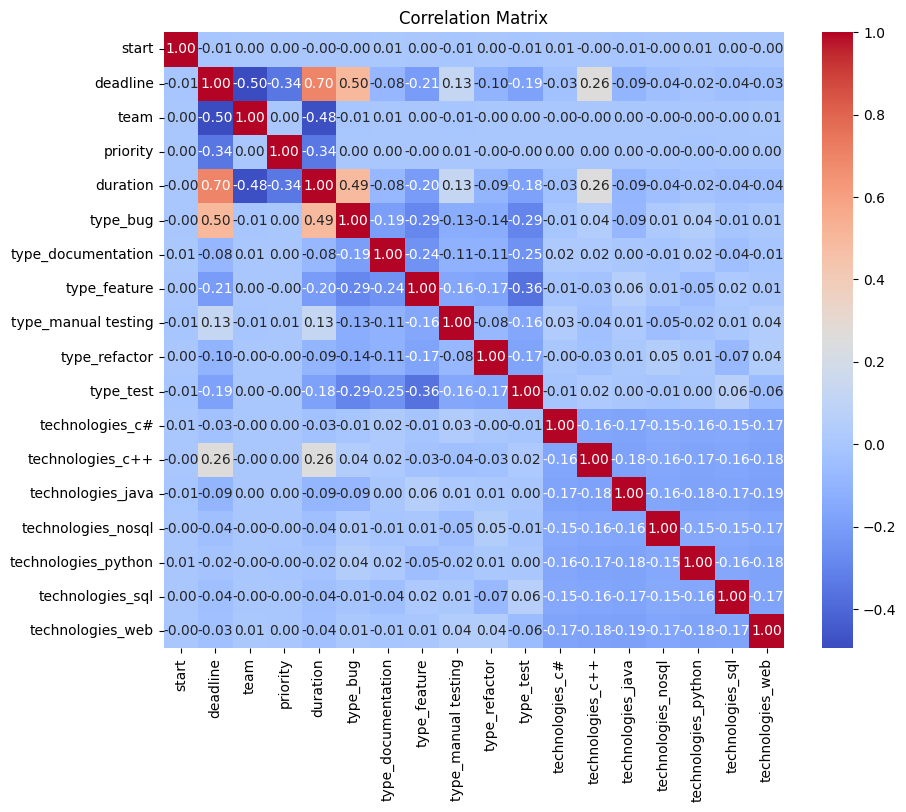

In [14]:
#correlation matrix
df_without_desc  = df_encoded.drop(columns=["desc"]) #cause too hard for the correlation matrix to generate
corr_matrix = df_without_desc.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

correlation with the output

In [15]:
#correlation between every feature and the duration
correlation = corr_matrix["duration"].sort_values(ascending=False)
correlation = correlation[correlation.index != "duration"]
print(correlation)

deadline               0.700459
type_bug               0.490399
technologies_c++       0.256550
type_manual testing    0.125428
start                 -0.003970
technologies_python   -0.021659
technologies_c#       -0.031149
technologies_web      -0.036895
technologies_nosql    -0.040126
technologies_sql      -0.042610
type_documentation    -0.077461
technologies_java     -0.087469
type_refactor         -0.094781
type_test             -0.182421
type_feature          -0.204500
priority              -0.340232
team                  -0.482951
Name: duration, dtype: float64


### Try a model to determine the duration

Decision Tree Regression

In [16]:
#split data between training and test sets

X = df_encoded.drop(columns=["duration", "desc"])
y = df_encoded["duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_reg = DecisionTreeRegressor()

#Function in order to round the prediction to the nearest integer, in order to be use in the GridSearchCV and cross validation
def custom_mse(y_true, y_pred):
    y_pred_rounded = np.round(y_pred).astype(int)
    return mean_squared_error(y_true, y_pred_rounded)

# Wrap the custom scorer with make_scorer
custom_scorer = make_scorer(custom_mse, greater_is_better=False)


#grid search
param_grid = [
    {'max_depth': [2,3,4,5,10,15,20,30,40,50], 'min_samples_split': [2,3,4,5,10,15,20,30,40,50,60,70], 'min_samples_leaf': [1,2,5,10,15,20,30,40,50]}
]
grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring=custom_scorer, return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters : ", grid_search.best_params_)
#final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
#round predictions to the nearest integer because duration is an integer
final_predictions = np.round(final_predictions).astype(int)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print("Final RMSE : ", final_rmse)

#cross validation
scores = cross_val_score(final_model, X_train, y_train, scoring=custom_scorer, cv=10)
final_rmse_scores = np.sqrt(-scores)
print("Final RMSE scores : ", final_rmse_scores)
print("Final RMSE scores mean : ", final_rmse_scores.mean())
print("Final RMSE scores std : ", final_rmse_scores.std())


#show the tree
output_file_path = "./data/task_duration_tree.dot"
export_graphviz(final_model, out_file=output_file_path, 
                feature_names=X.columns,  
                filled=True, rounded=True,  
                special_characters=True)

df_encoded["predicted_duration_with_tree"] = np.round(final_model.predict(X)).astype(int)
df_encoded["diff_with_tree"] = df_encoded["duration"] - df_encoded["predicted_duration_with_tree"]
df_encoded["diff_with_tree"] = df_encoded["diff_with_tree"].abs()
#save it to a csv
df_encoded.to_csv("./data/tasks_with_predictions.csv", index=False)
df_encoded.describe()


Best parameters :  {'max_depth': 15, 'min_samples_leaf': 50, 'min_samples_split': 2}
Final RMSE :  3.4956258381010974
Final RMSE scores :  [3.47383074 3.50777707 3.4631272  3.5255496  3.51343849 3.52022727
 3.56556447 3.49045126 3.39959556 3.47404663]
Final RMSE scores mean :  3.4933608294240104
Final RMSE scores std :  0.04248665020910975


,start,deadline,team,priority,duration,predicted_duration_with_tree,diff_with_tree
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,739209.512380,739222.015780,5.489180,1.000180,13.924080,13.924540,2.723740
std,1.117207,5.892533,2.878626,0.815471,6.016019,5.013225,2.047062
min,739208.000000,739209.000000,1.000000,0.000000,1.000000,4.000000,0.000000
25%,739209.000000,739218.000000,3.000000,0.000000,10.000000,10.000000,1.000000
50%,739210.000000,739221.000000,5.000000,1.000000,13.000000,14.000000,2.000000
75%,739211.000000,739226.000000,8.000000,2.000000,18.000000,17.000000,4.000000
max,739211.000000,739246.000000,10.000000,2.000000,38.000000,30.000000,14.000000


linear regression

In [17]:
#split data between training and test sets
X = df_encoded.drop(columns=["duration", "desc"])
y = df_encoded["duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#lets use linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)
final_predictions = lr.predict(X_test)
final_predictions = np.round(final_predictions).astype(int)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print("Final RMSE : ", final_rmse)
df_encoded["predicted_duration_with_linear"] = np.round(lr.predict(X)).astype(int)
df_encoded["diff_with_linear"] = df_encoded["duration"] - df_encoded["predicted_duration_with_linear"]
df_encoded["diff_with_linear"] = df_encoded["diff_with_linear"].abs()
#save it to a csv
df_encoded.to_csv("./data/tasks_with_predictions.csv", index=False)





Final RMSE :  3.432229596049775


### Compare each method graphically

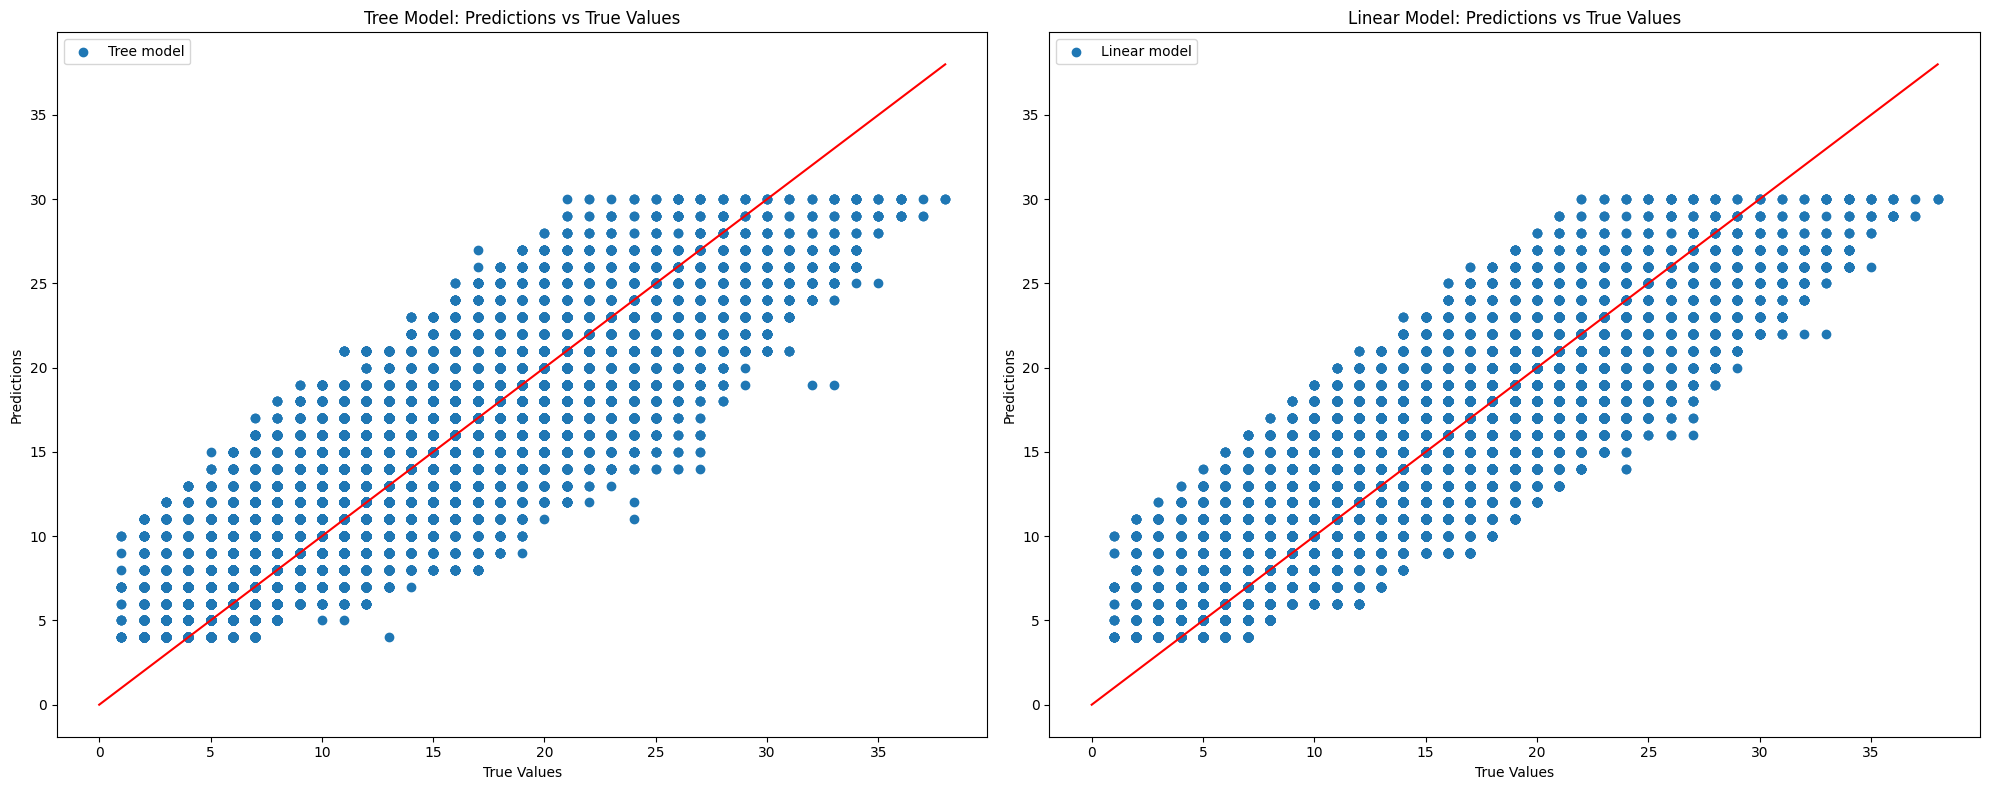

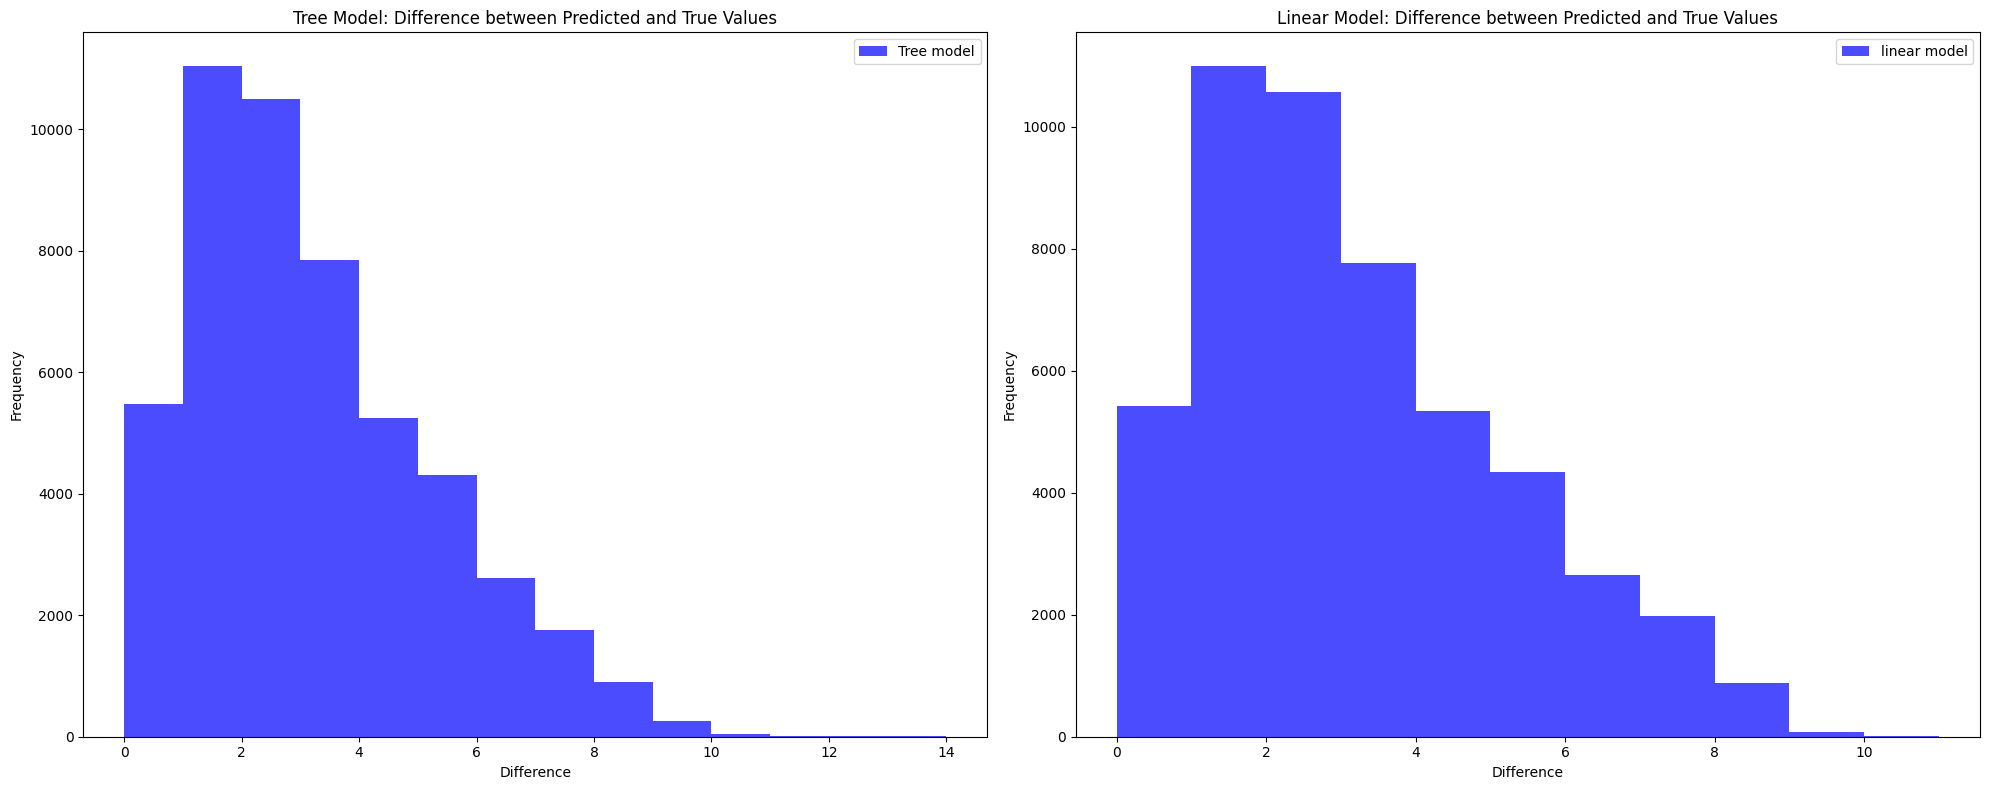

In [18]:
#lets compare using a graph the two models
#read the results data
result_df = pd.read_csv("./data/tasks_with_predictions.csv")

real_values = result_df["duration"]
predicted_values_tree = result_df["predicted_duration_with_tree"]
predicted_value_linear = result_df["predicted_duration_with_linear"]
max = real_values.max()
#plot the results (scatter plot)
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot for the Tree model
axs[0].scatter(real_values, predicted_values_tree, label="Tree model")
axs[0].plot([0, max], [0, max], color="red")
axs[0].set_xlabel("True Values")
axs[0].set_ylabel("Predictions")
axs[0].set_title("Tree Model: Predictions vs True Values")
axs[0].legend()

# Plot for the Linear model
axs[1].scatter(real_values, predicted_value_linear, label="Linear model")
axs[1].plot([0, max], [0, max], color="red")
axs[1].set_xlabel("True Values")
axs[1].set_ylabel("Predictions")
axs[1].set_title("Linear Model: Predictions vs True Values")
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


#plot the difference between the real value and the predicted value distribution
diff_tree = result_df["diff_with_tree"]
diff_linear = result_df["diff_with_linear"]
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
# Plot for the Tree model*
tree_max = diff_tree.max()
linear_max = diff_linear.max()
axs[0].hist(diff_tree, bins=tree_max, color="blue", alpha=0.7, label="Tree model")
axs[0].set_xlabel("Difference")
axs[0].set_ylabel("Frequency")
axs[0].set_title("Tree Model: Difference between Predicted and True Values")
axs[0].legend()
# Plot for the Linear model
axs[1].hist(diff_linear, bins=linear_max, color="blue", alpha=0.7, label="linear model")
axs[1].set_xlabel("Difference")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Linear Model: Difference between Predicted and True Values")
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()
